#  **Deep Neural Networks for Image Classification (Part II)**
#  **Convolutional Neural Networks (CNNs)**

*   We will create Convolutional Neural Networks (CNNs) for classifying MNIST and CIFAR10 images using PyTorch library, as in the previous lab. MNIST dataset contains 70,000 small square 28×28 pixel grayscale images of handwritten single digits between 0 and 9.

	• Use the GPU to speed up the training time of you models (Runtime -> Change runtime type -> Hardware accelerator -> GPU).

	• More details on PyTorch at https://pytorch.org/ - https://pytorch.org/tutorials/.  

# **MLP/CNN Contest**

*   [Submit results](https://forms.gle/BaYWQshbUjLna1ee6)
*   [Ranking Visualization](https://docs.google.com/spreadsheets/d/13kZPvlRs3H3smuRohcHimaOhmVkJtctp-NW5RJhLTjY/edit?usp=sharing)

In [ ]:
# Pytorch functions
import torch
# Neural network layers
import torch.nn as nn
import torch.nn.functional as F
# Optimizer
import torch.optim as optim
# Handling dataset
import torch.utils.data as data
# Torchvision library
import torchvision

import matplotlib.pyplot as plt
import random
import numpy as np
import copy
import time
import os
import cv2
# For results
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

*  Set "USE_SEED" to False for your own experiments.

In [ ]:
def set_seed(seed, use_gpu = True):
    """
    Set SEED for PyTorch reproducibility
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if use_gpu:
        torch.cuda.manual_seed_all(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

SEED = 44

USE_SEED = True

if USE_SEED:
    set_seed(SEED, torch.cuda.is_available())

# Convolutional and Max-Pooling layers
Let's see how to create max-pooling and convolutional layers using PyTorch.

  *  torch.nn.MaxPool2d(kernel_size, stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False)
  *  torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')


In [ ]:
# Define a "fake" image
image = torch.randn((1, 1, 28, 28)) # [batch_size, n_channels, height, width]
print(f"Image size: {image.shape}")

Image size: torch.Size([1, 1, 28, 28])


In [ ]:
max_pool = nn.MaxPool2d(kernel_size = 2)
img_max_pool = max_pool(image)

print(f"2D Max Pooling Output size: {img_max_pool.shape}")

2D Max Pooling Output size: torch.Size([1, 1, 14, 14])


In [ ]:
conv_2d = nn.Conv2d(in_channels = 1, out_channels = 64, kernel_size = 3)
img_conv_2d = conv_2d(image)

print(f"2D Conv Output size: {img_conv_2d.shape}")

2D Conv Output size: torch.Size([1, 64, 26, 26])


In [ ]:
print(conv_2d.weight.data.shape)
# Select first filter
print(conv_2d.weight.data[0][0])

torch.Size([64, 1, 3, 3])
tensor([[ 0.3050,  0.0840, -0.2269],
        [-0.2799,  0.2433,  0.1699],
        [-0.0929, -0.3318, -0.1995]])


In [ ]:
# We can also define our own kernel
f = torch.FloatTensor([[0, 0, 0],
                  [0, 1, 0],
                  [0, 0, 0]]) # Identity kernel

conv_2d.weight.data[0][0] = f

print(conv_2d.weight.data[0][0])

tensor([[0., 0., 0.],
        [0., 1., 0.],
        [0., 0., 0.]])


*  MNIST image classfication

In [ ]:
# Load MNIST dataset
# Available datasets at https://pytorch.org/vision/stable/datasets.html
ROOT = './data'
train_data = torchvision.datasets.MNIST(root=ROOT, train=True, download=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 93629078.10it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 31172335.00it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 42328543.43it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 19069598.37it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



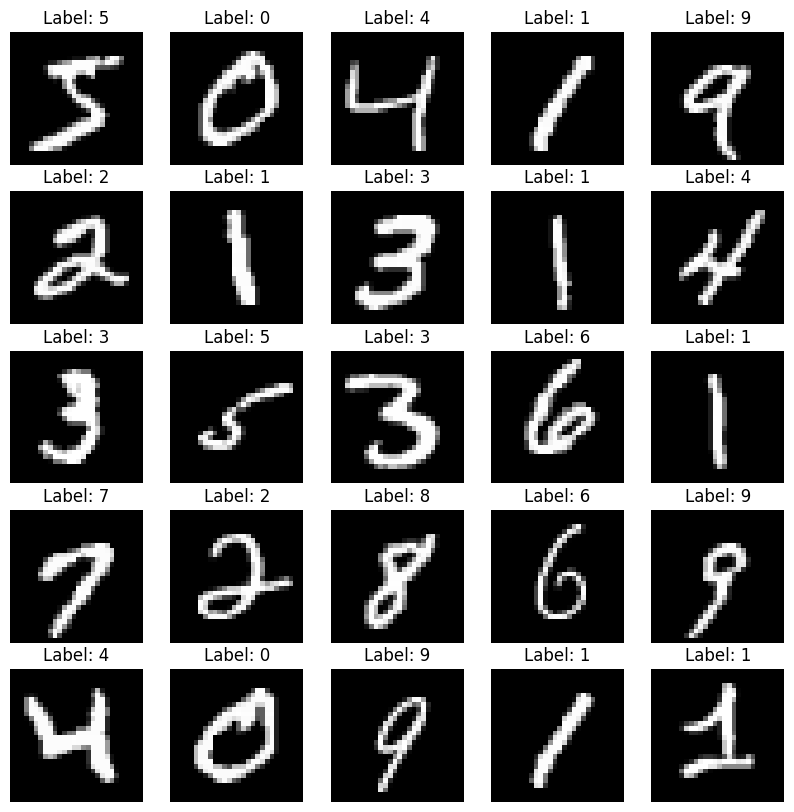

In [ ]:
# Plot some training images
N_IMAGES = 25
plt.figure(figsize=(10, 10))
for i in range(N_IMAGES):
  img = train_data.data[i] # Unnormalized images
  label = train_data[i][1]
  plt.subplot(5,5,i+1), plt.imshow(img, cmap='gray'), plt.title(f"Label: {label}"), plt.axis('off')

In [ ]:
# Select 1st image
min_px_value = train_data.data[0].min()
print(f"Minimum pixel value : {min_px_value}")
max_px_value = train_data.data[0].max()
print(f"Maximum pixel value : {max_px_value}")

Minimum pixel value : 0
Maximum pixel value : 255


In [ ]:
# Data normalization
# Mean and std should be divided by 255 (maximum pixel value)
# because, after the ToTensor() transformation (see next step), images are normalized
# between 0 and 1.

train_mean = train_data.data.float().mean() / 255
train_std = train_data.data.float().std() / 255

print("-----  TRAIN NORMALIZATION VALUES  -----")
print(f"Mean: {train_mean:.4f}")
print(f"Standard Deviation: {train_std:.4f}")

-----  TRAIN NORMALIZATION VALUES  -----
Mean: 0.1307
Standard Deviation: 0.3081


In [ ]:
# Compositions of transformations
train_transforms = torchvision.transforms.Compose([
                                                   torchvision.transforms.ToTensor(), # values are normalized between 0 and 1
                                                   torchvision.transforms.Normalize(train_mean, train_std)
])

test_transforms = torchvision.transforms.Compose([
                                                  torchvision.transforms.ToTensor(),
                                                  torchvision.transforms.Normalize(train_mean, train_std)
])

In [ ]:
# Load data with transformations
train_data = torchvision.datasets.MNIST(root=ROOT,
                                        train=True,
                                        download=True,
                                        transform=train_transforms)

test_data = torchvision.datasets.MNIST(root=ROOT,
                                        train=False,
                                        download=True,
                                        transform=test_transforms)
print(train_data)
print(test_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.13066047430038452, std=0.30810779333114624)
           )
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.13066047430038452, std=0.30810779333114624)
           )


In [ ]:
def create_validation_set(train_data, train_percentage, test_transforms):

  # Split train data into train and validation sets
  # (10% of training set will be used as validation set)
  num_train_examples = int(len(train_data) * train_percentage)
  num_valid_examples = len(train_data) - num_train_examples

  # Create 'Subset' objects
  train_data, valid_data = data.random_split(train_data, [num_train_examples, num_valid_examples])

  print(f"Number training examples: {len(train_data)}")
  print(f"Number validation examples: {len(valid_data)}")

  # Apply test transformations to the validation set
  valid_data = copy.deepcopy(valid_data) # If we change train transformations, this won't affect the validation set
  valid_data.dataset.transform = test_transforms

  return valid_data

In [ ]:
valid_data = create_validation_set(train_data, 0.8, test_transforms)

Number training examples: 48000
Number validation examples: 12000


In [ ]:
# Create iterators
BATCH_SIZE = 64

train_iterator = torch.utils.data.DataLoader(train_data,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE)

valid_iterator = torch.utils.data.DataLoader(valid_data,
                                             batch_size=BATCH_SIZE)

test_iterator = torch.utils.data.DataLoader(test_data,
                                            batch_size=BATCH_SIZE)

# **Ex.1**

Implement a LeNet-like architecture to classify handwritten digits. Compared to the original architecture, we will use 28x28 (instead of 32x32) input images and standard linear layers (we will not consider Gaussian connections).

	• INPUT: 28x28 grayscale image;
	• LAYER 1: Convolutional layer with 6 convolutional filters (select a padding value such that the output is a 28x28 feature map);
	• LAYER 2: A max pooling layer that down-samples Layer 1. Pass the output of Layer 2 through a ReLU activation function;
	• LAYER 3: Convolutional layer with 16 convolutional filters;
	• LAYER 4: A max pooling layer that down-samples Layer 3. Pass the output of Layer 4 through a ReLU activation function;
	• FLATTEN: Flatten the image to put it through linear layers;
	• LAYER 5: Linear layer (ouput dim = 120). Pass the output of Layer 5 through a ReLU activation function;
	• LAYER 6: Linear layer (ouput dim = 84). Pass the output of Layer 6 through a ReLU activation function;
	• LAYER 7: Linear layer (ouput dim = 10)

You can infer the kernel size of each convolutional layer from the image below.

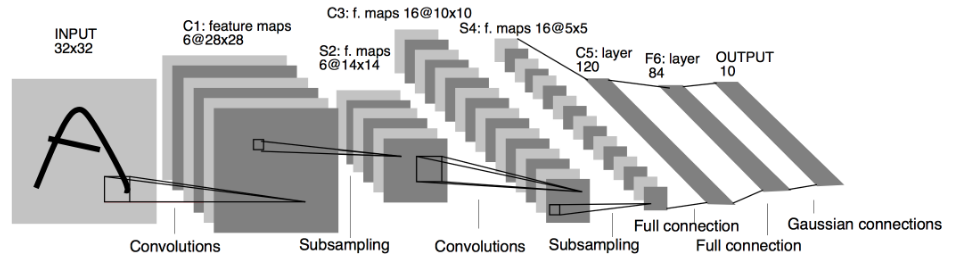

**Ex. 1.1** - Compute the number of parameters for each layer of the previous network.

Number of parameters (Conv Layer) = Filter Size x Filter Size x Number of
Filters x Input Depth + Biases
Number of parameters (Linear Layer) = Input Size x Output Size + Biases
* Layer C1 -> 5x5x6x1+6 = 156
* Layer C3 -> 5x5x16x6+16 = 2,416
* Layer C5 -> 5x5x16x120+120 = 48,120
* Layer F6 -> 120*84+84 = 10,164
* Layer OUT -> 84*10+10 = 850
---
Total number of parameters = 61,706

In [ ]:
class LeNet(nn.Module):
  def __init__(self, output_dim):
    super().__init__()

    """ YOUR CODE HERE"""

    self.features = nn.Sequential(
      nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2),
      nn.MaxPool2d(kernel_size=2),
      nn.ReLU(),
      nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
      nn.MaxPool2d(kernel_size=2),
      nn.ReLU()
    )
    
    self.linear = nn.Sequential(
      nn.Linear(16 * 5 * 5, 120),
      nn.ReLU(),
      nn.Linear(120, 84),
      nn.ReLU(),
      nn.Linear(84, output_dim)
    )
    
  def forward(self, x):
    x = self.features(x)
    x = x.view(x.shape[0], -1)
    x = self.linear(x)
    return x

In [ ]:
OUTPUT_DIM = 10
model = LeNet(OUTPUT_DIM)

In [ ]:
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"The model has {count_parameters(model):,} trainable parameters.")

The model has 61,706 trainable parameters.


In [ ]:
# Loss
criterion = nn.CrossEntropyLoss() # Softmax + CrossEntropy

# Put model&criterion on GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

criterion = criterion.to(device)

In [ ]:
# Optim
optimizer = optim.Adam(model.parameters(), lr=1e-4)

model = model.to(device)

* Training phase

In [ ]:
def train(model, iterator, optimizer, criterion, device):
  epoch_loss = 0
  epoch_acc = 0

  # Train mode
  model.train()

  for (x,y) in iterator:
    x = x.to(device)
    y = y.to(device)
    # Set gradients to zero
    optimizer.zero_grad()

    # Make Predictions
    y_pred = model(x)

    # Compute loss
    loss = criterion(y_pred, y)

    # Compute accuracy
    acc = calculate_accuracy(y_pred, y)

    # Backprop
    loss.backward()

    # Apply optimizer
    optimizer.step()

    # Extract data from loss and accuracy
    epoch_loss += loss.item()
    epoch_acc += acc.item()

  return epoch_loss/len(iterator), epoch_acc/len(iterator)

* Validation/Testing phase

In [ ]:
def evaluate(model, iterator, criterion, device):
  epoch_loss = 0
  epoch_acc = 0

  # Evaluation mode
  model.eval()

  # Do not compute gradients
  with torch.no_grad():

    for(x,y) in iterator:

      x = x.to(device)
      y = y.to(device)

      # Make Predictions
      y_pred = model(x)

      # Compute loss
      loss = criterion(y_pred, y)

      # Compute accuracy
      acc = calculate_accuracy(y_pred, y)

      # Extract data from loss and accuracy
      epoch_loss += loss.item()
      epoch_acc += acc.item()

  return epoch_loss/len(iterator), epoch_acc/len(iterator)

In [ ]:
def calculate_accuracy(y_pred, y):
  '''
  Compute accuracy from ground-truth and predicted labels.

  Input
  ------
  y_pred: torch.Tensor [BATCH_SIZE, N_LABELS]
  y: torch.Tensor [BATCH_SIZE]

  Output
  ------
  acc: float
    Accuracy
  '''
  y_prob = F.softmax(y_pred, dim = -1)
  y_pred = y_pred.argmax(dim=1, keepdim = True)
  correct = y_pred.eq(y.view_as(y_pred)).sum()
  acc = correct.float()/y.shape[0]
  return acc

In [ ]:
def model_training(n_epochs, model, train_iterator, valid_iterator, optimizer, criterion, device, model_name='best_model.pt'):

  # Initialize validation loss
  best_valid_loss = float('inf')

  # Save output losses, accs
  train_losses = []
  train_accs = []
  valid_losses = []
  valid_accs = []

  # Loop over epochs
  for epoch in range(n_epochs):
    start_time = time.time()
    # Train
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    # Validation
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)
    # Save best model
    if valid_loss < best_valid_loss:
      best_valid_loss = valid_loss
      # Save model
      torch.save(model.state_dict(), model_name)
    end_time = time.time()

    print(f"\nEpoch: {epoch+1}/{n_epochs} -- Epoch Time: {end_time-start_time:.2f} s")
    print("---------------------------------")
    print(f"Train -- Loss: {train_loss:.3f}, Acc: {train_acc * 100:.2f}%")
    print(f"Val -- Loss: {valid_loss:.3f}, Acc: {valid_acc * 100:.2f}%")

    # Save
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)

  return train_losses, train_accs, valid_losses, valid_accs

In [ ]:
N_EPOCHS = 30
train_losses, train_accs, valid_losses, valid_accs = model_training(N_EPOCHS,
                                                                    model,
                                                                    train_iterator,
                                                                    valid_iterator,
                                                                    optimizer,
                                                                    criterion,
                                                                    device,
                                                                    'lenet.pt')


Epoch: 1/30 -- Epoch Time: 23.64 s
---------------------------------
Train -- Loss: 0.651, Acc: 83.29%
Val -- Loss: 0.242, Acc: 92.94%

Epoch: 2/30 -- Epoch Time: 24.27 s
---------------------------------
Train -- Loss: 0.192, Acc: 94.40%
Val -- Loss: 0.150, Acc: 95.44%

Epoch: 3/30 -- Epoch Time: 17.21 s
---------------------------------
Train -- Loss: 0.131, Acc: 96.08%
Val -- Loss: 0.111, Acc: 96.72%

Epoch: 4/30 -- Epoch Time: 16.90 s
---------------------------------
Train -- Loss: 0.101, Acc: 96.94%
Val -- Loss: 0.086, Acc: 97.39%

Epoch: 5/30 -- Epoch Time: 17.36 s
---------------------------------
Train -- Loss: 0.084, Acc: 97.45%
Val -- Loss: 0.077, Acc: 97.60%

Epoch: 6/30 -- Epoch Time: 16.57 s
---------------------------------
Train -- Loss: 0.072, Acc: 97.84%
Val -- Loss: 0.071, Acc: 97.81%

Epoch: 7/30 -- Epoch Time: 24.70 s
---------------------------------
Train -- Loss: 0.064, Acc: 98.00%
Val -- Loss: 0.059, Acc: 98.21%

Epoch: 8/30 -- Epoch Time: 16.35 s
------------

In [ ]:
def plot_results(n_epochs, train_losses, train_accs, valid_losses, valid_accs):
  N_EPOCHS = n_epochs
  # Plot results
  plt.figure(figsize=(20, 6))
  _ = plt.subplot(1,2,1)
  plt.plot(np.arange(N_EPOCHS)+1, train_losses, linewidth=3)
  plt.plot(np.arange(N_EPOCHS)+1, valid_losses, linewidth=3)
  _ = plt.legend(['Train', 'Validation'])
  plt.grid('on'), plt.xlabel('Epoch'), plt.ylabel('Loss')

  _ = plt.subplot(1,2,2)
  plt.plot(np.arange(N_EPOCHS)+1, train_accs, linewidth=3)
  plt.plot(np.arange(N_EPOCHS)+1, valid_accs, linewidth=3)
  _ = plt.legend(['Train', 'Validation'])
  plt.grid('on'), plt.xlabel('Epoch'), plt.ylabel('Accuracy')

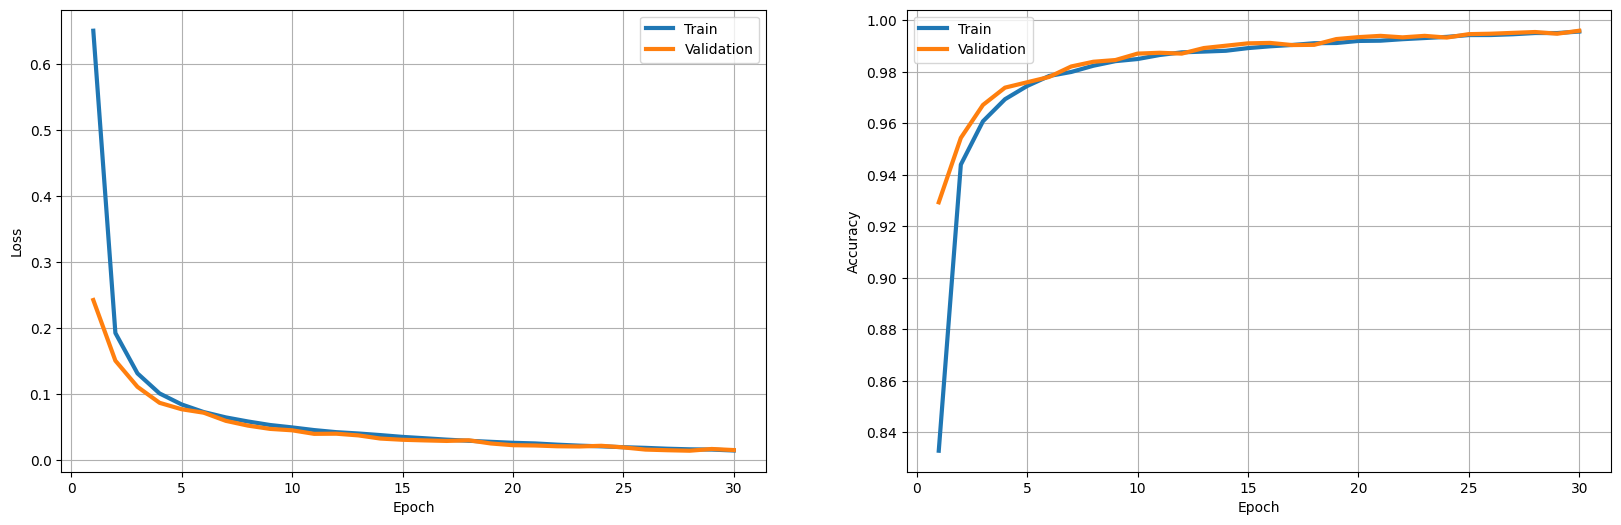

In [ ]:
plot_results(N_EPOCHS, train_losses, train_accs, valid_losses, valid_accs)

In [ ]:
def model_testing(model, test_iterator, criterion, device, model_name='best_model.pt'):
  # Test model
  model.load_state_dict(torch.load(model_name))
  test_loss, test_acc = evaluate(model, test_iterator, criterion, device)
  print(f"Test -- Loss: {test_loss:.3f}, Acc: {test_acc * 100:.2f} %")

In [ ]:
model_testing(model, test_iterator, criterion, device, 'lenet.pt')

Test -- Loss: 0.034, Acc: 98.94 %


In [ ]:
def predict(model, iterator, device):

  # Evaluation mode
  model.eval()

  labels = []
  pred = []

  with torch.no_grad():
    for (x, y) in iterator:
      x = x.to(device)
      y_pred = model(x)

      # Get label with highest score
      y_prob = F.softmax(y_pred, dim = -1)
      top_pred = y_prob.argmax(1, keepdim=True)

      labels.append(y.cpu())
      pred.append(top_pred.cpu())

  labels = torch.cat(labels, dim=0)
  pred = torch.cat(pred, dim=0)

  return labels, pred


In [ ]:
def print_report(model, test_iterator, device):
  labels, pred = predict(model, test_iterator, device)
  print(confusion_matrix(labels, pred))
  print("\n")
  print(classification_report(labels, pred))

In [ ]:
print_report(model, test_iterator, device)

[[ 976    0    0    0    0    0    1    1    2    0]
 [   0 1127    1    0    0    1    1    2    3    0]
 [   1    0 1023    3    0    0    0    3    2    0]
 [   0    0    0 1004    0    3    0    0    3    0]
 [   0    0    2    0  965    0    1    2    2   10]
 [   2    0    0    4    0  884    1    0    1    0]
 [   4    2    0    1    1    6  942    0    2    0]
 [   0    0    5    2    0    0    0 1019    1    1]
 [   2    0    1    1    0    2    0    2  963    3]
 [   1    0    0    3    2    5    1    5    2  990]]


              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       1.00      0.99      1.00      1135
           2       0.99      0.99      0.99      1032
           3       0.99      0.99      0.99      1010
           4       1.00      0.98      0.99       982
           5       0.98      0.99      0.99       892
           6       0.99      0.98      0.99       958
           7       0.99      0.99 

# **Feature Maps Visualization**

We will now visualize some filters and feature maps, selecting the first 5 test images and the first CONV layer.

CONV1 LAYER: torch.Size([6, 1, 5, 5])


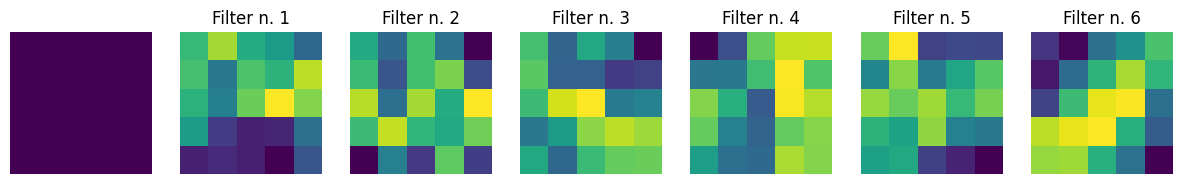

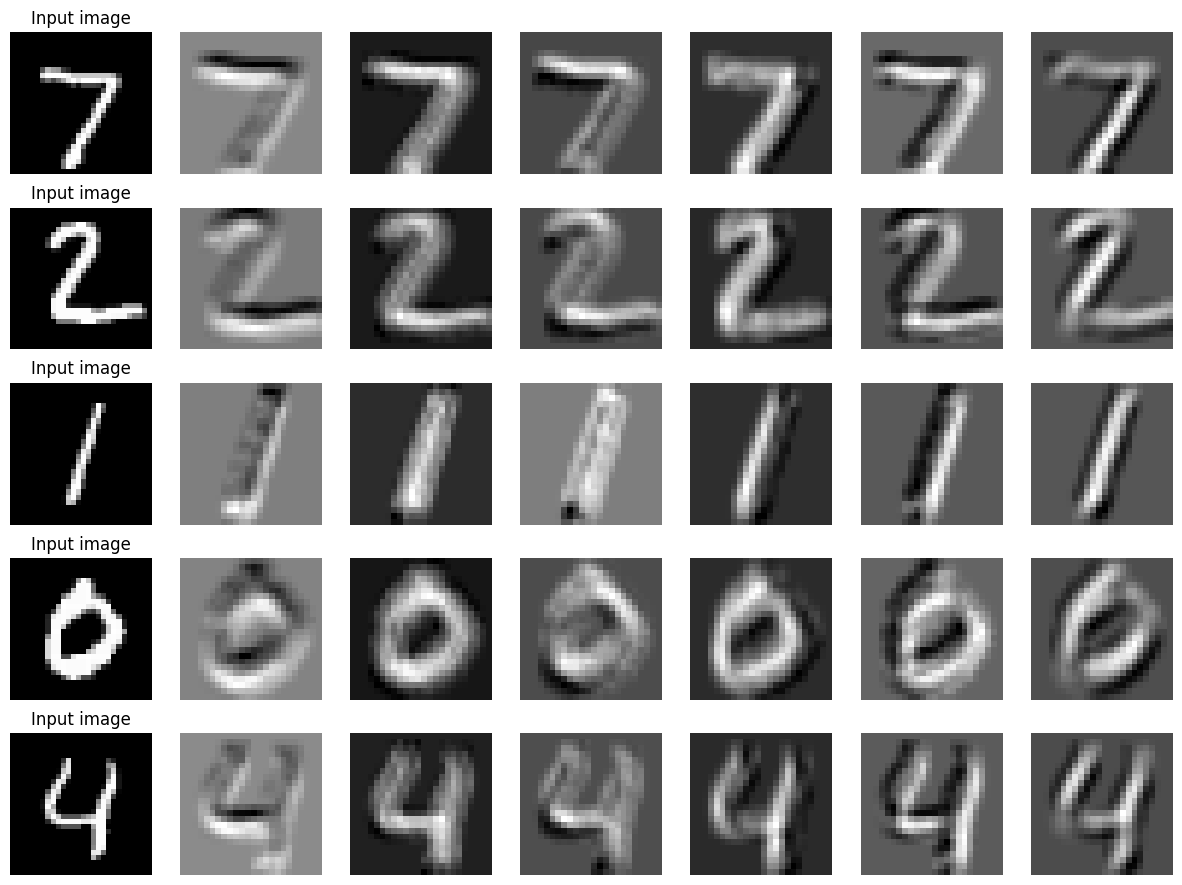

In [ ]:
N_IMAGES = 5

# Get filters
filters = model.features[0].weight.data
print(f"CONV1 LAYER: {filters.shape}")

fig = plt.figure(figsize=(15,10))
for i in range(filters.shape[0]):
  if i == 0:
    plt.subplot(1, 7, i+1), plt.imshow(torch.zeros(filters.size(2), filters.size(3)).cpu()), plt.axis('off')
  image = filters[i][0]
  # image.clamp_(min = image.min(), max = image.max())
  # image.add_(-image.min()).div_(image.max() - image.min() + 1e-5)
  plt.subplot(1, 7, i+2), plt.imshow(image.cpu()), plt.title(f"Filter n. {i+1}")
  plt.axis('off')

# Select images
images = [image for image, label in [test_data[i] for i in range(N_IMAGES)]]

# Parameters
in_channels = filters.shape[1]
out_channels = filters.shape[0]
kernel_size = filters.shape[2]
# # Define 2d filter
filter_2d = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size).to(device)
filter_2d.weight.data = filters

N_FILTERS = out_channels
fig = plt.figure(figsize=(15,11))
for i in range(N_IMAGES):
  # Plot image
  image = images[i]
  image = image[None, ...]
  plt.subplot(5, N_FILTERS+1, i+1 + (N_FILTERS*i)), plt.imshow(image[0][0].cpu(), cmap = 'gray'), plt.axis('off')
  plt.title('Input image')

  # Plot filtered image
  filtered_image = filter_2d(image.to(device))
  for f in range(N_FILTERS):
    fil_image = filtered_image[0][f]
    plt.subplot(5, N_FILTERS+1, f+2 + ((N_FILTERS+1)*i)), plt.imshow(fil_image.cpu().detach().numpy(), cmap = 'gray'), plt.axis('off')

# Import a convolutional neural network

*  Load CIFAR10 dataset;
*  Import VGG16 architecure;
*  Train VGG16 on CIFAR 10 from scratch or using a VGG-16 pre-trained on ImageNet.

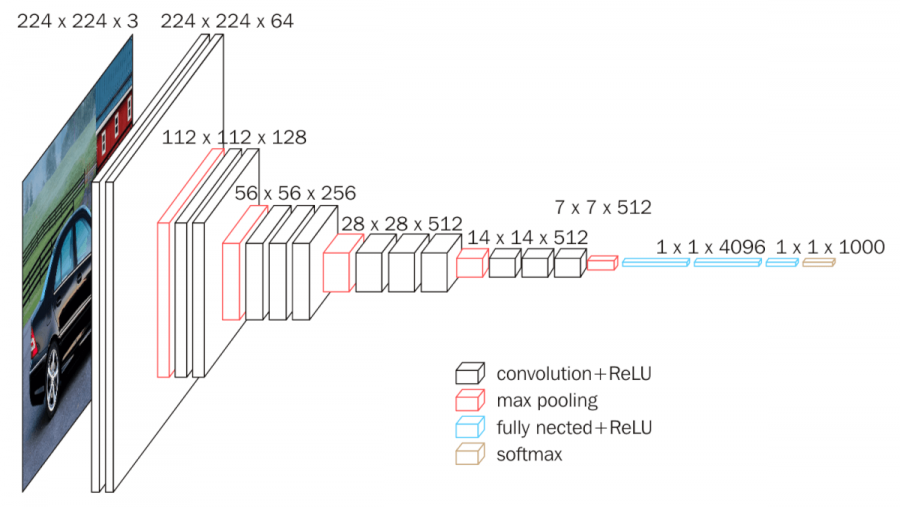

In [ ]:
# Load CIFAR10 dataset
# Available datasets at https://pytorch.org/vision/stable/datasets.html
ROOT = './data'
train_data = torchvision.datasets.CIFAR10(root=ROOT, train=True, download=True)

# You can also use the 'transform' argument to specify transformations to apply to the dataset
# e.g. 'train_data = torchvision.datasets.CIFAR10(root=ROOT, train=True, download=True, transform=...)'
# See the next steps for applying transformations to a dataset.

100%|██████████| 170498071/170498071 [00:04<00:00, 37893547.66it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [ ]:
# -----  TRAIN NORMALIZATION VALUES  -----
# Refer to the previous lab to compute mean and std.
train_mean =  [0.49139968, 0.48215841, 0.44653091]
train_std = [0.24703223, 0.24348513, 0.26158784]

*   We will use 32x32 pixel as image size instead of 224x224 to speed up the training time. You can also try to add the resize transformation.

In [ ]:
# Compositions of transformations
train_transforms = torchvision.transforms.Compose([
                                                  #torchvision.transforms.Resize((224,224)),
                                                   torchvision.transforms.ToTensor(), # values are normalized between 0 and 1
                                                   torchvision.transforms.Normalize(train_mean, train_std)
])

test_transforms = torchvision.transforms.Compose([
                                                 #torchvision.transforms.Resize((224,224)),
                                                  torchvision.transforms.ToTensor(),
                                                  torchvision.transforms.Normalize(train_mean, train_std)
])

In [ ]:
# Load data with transformations
train_data = torchvision.datasets.CIFAR10(root=ROOT,
                                        train=True,
                                        download=True,
                                        transform=train_transforms)

test_data = torchvision.datasets.CIFAR10(root=ROOT,
                                        train=False,
                                        download=True,
                                        transform=test_transforms)
print(train_data)
print(test_data)

Files already downloaded and verified
Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.49139968, 0.48215841, 0.44653091], std=[0.24703223, 0.24348513, 0.26158784])
           )
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.49139968, 0.48215841, 0.44653091], std=[0.24703223, 0.24348513, 0.26158784])
           )


In [ ]:
valid_data = create_validation_set(train_data, 0.8, test_transforms)

Number training examples: 40000
Number validation examples: 10000


In [ ]:
# Create iterators
BATCH_SIZE = 128

train_iterator = torch.utils.data.DataLoader(train_data,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE)

valid_iterator = torch.utils.data.DataLoader(valid_data,
                                             batch_size=BATCH_SIZE)

test_iterator = torch.utils.data.DataLoader(test_data,
                                            batch_size=BATCH_SIZE)

In [ ]:
%%capture
vgg16 = torchvision.models.vgg16(pretrained = False)

In [ ]:
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

*  Let's modify the 'classifier' section of the VGG16 network since out dataset contains 10 classes.

In [ ]:
print(vgg16.classifier[-1])
print(f"Input features: {vgg16.classifier[-1].in_features}")
print(f"Output features: {vgg16.classifier[-1].out_features}")

Linear(in_features=4096, out_features=1000, bias=True)
Input features: 4096
Output features: 1000


In [ ]:
print(f'The model has {count_parameters(vgg16):,} trainable parameters')

The model has 138,357,544 trainable parameters


In [ ]:
for p in vgg16.classifier[-1].parameters():
  print(p.shape)

torch.Size([1000, 4096])
torch.Size([1000])


In [ ]:
OUTPUT_DIM = 10
vgg16.classifier[-1] = nn.Linear(vgg16.classifier[-1].in_features, OUTPUT_DIM)

In [ ]:
print(vgg16.classifier)

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=10, bias=True)
)


In [ ]:
print(f'The model has {count_parameters(vgg16):,} trainable parameters')

The model has 134,301,514 trainable parameters


In [ ]:
for p in vgg16.classifier[-1].parameters():
  print(p.shape)

torch.Size([10, 4096])
torch.Size([10])


In [ ]:
# Optim
optimizer = optim.Adam(vgg16.parameters(), lr=1e-5)

vgg16 = vgg16.to(device)

In [ ]:
N_EPOCHS = 30
train_losses_vgg16_scratch, train_accs_vgg16_scratch, valid_losses_vgg16_scratch, valid_accs_vgg16_scratch = model_training(N_EPOCHS,
                                                                                                                            vgg16,
                                                                                                                            train_iterator,
                                                                                                                            valid_iterator,
                                                                                                                            optimizer,
                                                                                                                            criterion,
                                                                                                                            device,
                                                                                                                            'vgg16.pt')


Epoch: 1/30 -- Epoch Time: 56.29 s
---------------------------------
Train -- Loss: 1.954, Acc: 25.51%
Val -- Loss: 1.674, Acc: 37.33%

Epoch: 2/30 -- Epoch Time: 60.09 s
---------------------------------
Train -- Loss: 1.575, Acc: 40.47%
Val -- Loss: 1.434, Acc: 46.73%

Epoch: 3/30 -- Epoch Time: 60.78 s
---------------------------------
Train -- Loss: 1.423, Acc: 47.56%
Val -- Loss: 1.310, Acc: 51.52%

Epoch: 4/30 -- Epoch Time: 61.32 s
---------------------------------
Train -- Loss: 1.308, Acc: 52.32%
Val -- Loss: 1.222, Acc: 54.91%

Epoch: 5/30 -- Epoch Time: 60.74 s
---------------------------------
Train -- Loss: 1.219, Acc: 55.67%
Val -- Loss: 1.191, Acc: 56.32%

Epoch: 6/30 -- Epoch Time: 60.72 s
---------------------------------
Train -- Loss: 1.145, Acc: 58.68%
Val -- Loss: 1.077, Acc: 60.21%

Epoch: 7/30 -- Epoch Time: 61.58 s
---------------------------------
Train -- Loss: 1.075, Acc: 61.28%
Val -- Loss: 0.969, Acc: 64.89%

Epoch: 8/30 -- Epoch Time: 61.32 s
------------

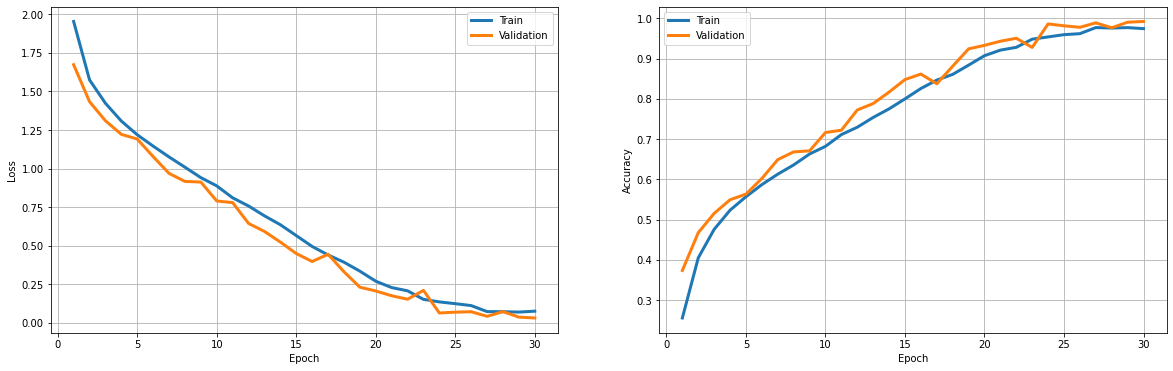

In [ ]:
plot_results(N_EPOCHS, train_losses_vgg16_scratch, train_accs_vgg16_scratch, valid_losses_vgg16_scratch, valid_accs_vgg16_scratch)

In [ ]:
model_testing(vgg16, test_iterator, criterion, device, 'vgg16.pt')

Test -- Loss: 2.029, Acc: 64.51 %


In [ ]:
print_report(vgg16, test_iterator, device)

[[736  34  43  29  26   8   7  12  71  34]
 [ 23 791   8  12   7   7   9   7  26 110]
 [ 82  12 505  73 123 100  57  27  11  10]
 [ 26  15  74 420  78 241  67  38  18  23]
 [ 33   4  91  53 626  54  72  52  10   5]
 [ 23   9  65 177  63 576  21  53   4   9]
 [  8  18  51  72  80  36 709   6   2  18]
 [ 30  14  30  43 102  91   8 657   1  24]
 [108  54  13  15  14  12   7   3 734  40]
 [ 47 151   6  22  10  14  15  22  21 692]]


              precision    recall  f1-score   support

           0       0.66      0.74      0.70      1000
           1       0.72      0.79      0.75      1000
           2       0.57      0.51      0.54      1000
           3       0.46      0.42      0.44      1000
           4       0.55      0.63      0.59      1000
           5       0.51      0.58      0.54      1000
           6       0.73      0.71      0.72      1000
           7       0.75      0.66      0.70      1000
           8       0.82      0.73      0.77      1000
           9       0.72   

# Transfer Learning


*  Finetuning
*  Feature extraction

In finetuning, we use a pretrained model and update all of its parameters for the new task (**the whole model is retrained**). In feature extraction, we use a pretrained model and only update the final layer(s) weights. In this case, we use a pretrained CNN as a **fixed** feature-extractor, and only change its output layer(s).

Steps for both transfer learning methods:

*  Initialize a pretrained model;
*  Reshape the final layer(s) to match number of outputs and number of classes in the new dataset;
*  Define which parameters must be updated during training;
*  Train the network.

*  Data normalization

From the PyTorch website (https://pytorch.org/vision/stable/models.html):

> All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225].

In [ ]:
# Normalize CIFAR10
mean_imagenet = [0.485, 0.456, 0.406]
std_imagenet = [0.229, 0.224, 0.225]

In [ ]:
# Compositions of transformations
train_transforms = torchvision.transforms.Compose([
                                                    #torchvision.transforms.Resize((224,224)),
                                                    torchvision.transforms.RandomHorizontalFlip(),
                                                    torchvision.transforms.ToTensor(), # values are normalized between 0 and 1
                                                    torchvision.transforms.Normalize(mean_imagenet, std_imagenet)
])

test_transforms = torchvision.transforms.Compose([
                                                    #torchvision.transforms.Resize((224,224)),
                                                    torchvision.transforms.ToTensor(),
                                                    torchvision.transforms.Normalize(mean_imagenet, std_imagenet)
])

In [ ]:
# Load data with transformations
train_data = torchvision.datasets.CIFAR10(root=ROOT,
                                        train=True,
                                        download=True,
                                        transform=train_transforms)

test_data = torchvision.datasets.CIFAR10(root=ROOT,
                                        train=False,
                                        download=True,
                                        transform=test_transforms)
print(train_data)
print(test_data)

Files already downloaded and verified
Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


In [ ]:
valid_data = create_validation_set(train_data, 0.8, test_transforms)

Number training examples: 40000
Number validation examples: 10000


In [ ]:
# Create iterators
BATCH_SIZE = 128

train_iterator = torch.utils.data.DataLoader(train_data,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE)

valid_iterator = torch.utils.data.DataLoader(valid_data,
                                             batch_size=BATCH_SIZE)

test_iterator = torch.utils.data.DataLoader(test_data,
                                            batch_size=BATCH_SIZE)

*  Finetuning

In [ ]:
%%capture
vgg16_fine_tuning = torchvision.models.vgg16(pretrained = True) # Load weights

In [ ]:
print(vgg16_fine_tuning.classifier[-1])

Linear(in_features=4096, out_features=1000, bias=True)


In [ ]:
# Define new output layer
OUTPUT_DIM = 10
vgg16_fine_tuning.classifier[-1] = nn.Linear(vgg16_fine_tuning.classifier[-1].in_features, OUTPUT_DIM)

In [ ]:
# Optim
optimizer = optim.Adam(vgg16_fine_tuning.parameters(), lr=1e-5)

vgg16_fine_tuning = vgg16_fine_tuning.to(device)

In [ ]:
N_EPOCHS = 30
train_losses_vgg16_fine_tuning, train_accs_vgg16_fine_tuning, valid_losses_vgg16_fine_tuning, valid_accs_vgg16_fine_tuning = model_training(N_EPOCHS,
                                                                                                                            vgg16_fine_tuning,
                                                                                                                            train_iterator,
                                                                                                                            valid_iterator,
                                                                                                                            optimizer,
                                                                                                                            criterion,
                                                                                                                            device,
                                                                                                                            'vgg16_fine_tuning.pt')


Epoch: 1/30 -- Epoch Time: 61.78 s
---------------------------------
Train -- Loss: 1.106, Acc: 61.71%
Val -- Loss: 0.635, Acc: 78.20%

Epoch: 2/30 -- Epoch Time: 61.90 s
---------------------------------
Train -- Loss: 0.630, Acc: 78.53%
Val -- Loss: 0.507, Acc: 82.78%

Epoch: 3/30 -- Epoch Time: 62.33 s
---------------------------------
Train -- Loss: 0.515, Acc: 82.54%
Val -- Loss: 0.433, Acc: 85.07%

Epoch: 4/30 -- Epoch Time: 62.42 s
---------------------------------
Train -- Loss: 0.438, Acc: 85.08%
Val -- Loss: 0.365, Acc: 87.21%

Epoch: 5/30 -- Epoch Time: 61.97 s
---------------------------------
Train -- Loss: 0.384, Acc: 86.76%
Val -- Loss: 0.320, Acc: 89.19%

Epoch: 6/30 -- Epoch Time: 62.06 s
---------------------------------
Train -- Loss: 0.333, Acc: 88.68%
Val -- Loss: 0.285, Acc: 89.96%

Epoch: 7/30 -- Epoch Time: 64.37 s
---------------------------------
Train -- Loss: 0.294, Acc: 89.96%
Val -- Loss: 0.244, Acc: 91.70%

Epoch: 8/30 -- Epoch Time: 61.14 s
------------

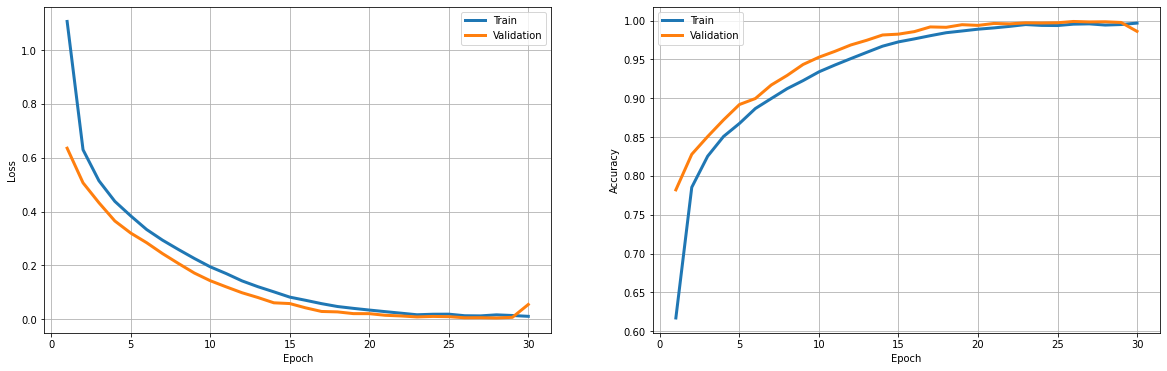

In [ ]:
plot_results(N_EPOCHS, train_losses_vgg16_fine_tuning, train_accs_vgg16_fine_tuning, valid_losses_vgg16_fine_tuning, valid_accs_vgg16_fine_tuning)

In [ ]:
model_testing(vgg16_fine_tuning, test_iterator, criterion, device, 'vgg16_fine_tuning.pt')

Test -- Loss: 0.975, Acc: 87.43 %


In [ ]:
print_report(vgg16_fine_tuning, test_iterator, device)

[[896   6  22   6  12   2   2   7  36  11]
 [ 11 947   0   2   1   0   0   0  12  27]
 [ 13   0 849  33  42  23  27   9   3   1]
 [  5   5  38 744  47  94  38  21   3   5]
 [  3   1  37  17 884  16  19  15   6   2]
 [  3   0  30 138  30 763   9  26   1   0]
 [  4   1  23  25  16   5 922   1   2   1]
 [  7   1  17  15  39  27   4 883   3   4]
 [ 26   6   6   3   2   1   0   0 950   6]
 [ 11  50   0   3   0   0   1   0  16 919]]


              precision    recall  f1-score   support

           0       0.92      0.90      0.91      1000
           1       0.93      0.95      0.94      1000
           2       0.83      0.85      0.84      1000
           3       0.75      0.74      0.75      1000
           4       0.82      0.88      0.85      1000
           5       0.82      0.76      0.79      1000
           6       0.90      0.92      0.91      1000
           7       0.92      0.88      0.90      1000
           8       0.92      0.95      0.94      1000
           9       0.94   

* Feature extraction


In [ ]:
%%capture
vgg16_feat_extract = torchvision.models.vgg16(pretrained = True) # Load weights

In [ ]:
OUTPUT_DIM = 10
vgg16_feat_extract.classifier[-1] = nn.Linear(vgg16_feat_extract.classifier[-1].in_features, OUTPUT_DIM)

In [ ]:
# Freeze all "features" layers
for parameter in vgg16_feat_extract.features.parameters():
  parameter.requires_grad = False
# Uncomment the following line to freeze all the "classifier" layers but the last FC layer
# for parameter in vgg16_feat_extract.classifier[:-1].parameters():
#   parameter.requires_grad = False

In [ ]:
# Optim
optimizer = optim.SGD(vgg16_feat_extract.parameters(), lr=1e-3)

vgg16_feat_extract = vgg16_feat_extract.to(device)

In [ ]:
N_EPOCHS = 30
train_losses_vgg16_feat_extract, train_accs_vgg16_feat_extract, valid_losses_vgg16_feat_extract, valid_accs_vgg16_feat_extract = model_training(N_EPOCHS,
                                                                                                                            vgg16_feat_extract,
                                                                                                                            train_iterator,
                                                                                                                            valid_iterator,
                                                                                                                            optimizer,
                                                                                                                            criterion,
                                                                                                                            device,
                                                                                                                            'vgg16_feat_extract.pt')


Epoch: 1/30 -- Epoch Time: 33.87 s
---------------------------------
Train -- Loss: 1.556, Acc: 46.18%
Val -- Loss: 1.159, Acc: 59.84%

Epoch: 2/30 -- Epoch Time: 34.45 s
---------------------------------
Train -- Loss: 1.270, Acc: 55.99%
Val -- Loss: 1.081, Acc: 62.20%

Epoch: 3/30 -- Epoch Time: 35.80 s
---------------------------------
Train -- Loss: 1.198, Acc: 58.37%
Val -- Loss: 1.043, Acc: 63.83%

Epoch: 4/30 -- Epoch Time: 35.26 s
---------------------------------
Train -- Loss: 1.160, Acc: 59.53%
Val -- Loss: 1.014, Acc: 64.59%

Epoch: 5/30 -- Epoch Time: 35.68 s
---------------------------------
Train -- Loss: 1.128, Acc: 60.57%
Val -- Loss: 0.997, Acc: 64.94%

Epoch: 6/30 -- Epoch Time: 35.39 s
---------------------------------
Train -- Loss: 1.107, Acc: 61.31%
Val -- Loss: 0.980, Acc: 65.62%

Epoch: 7/30 -- Epoch Time: 35.47 s
---------------------------------
Train -- Loss: 1.089, Acc: 61.79%
Val -- Loss: 0.972, Acc: 66.12%

Epoch: 8/30 -- Epoch Time: 33.38 s
------------

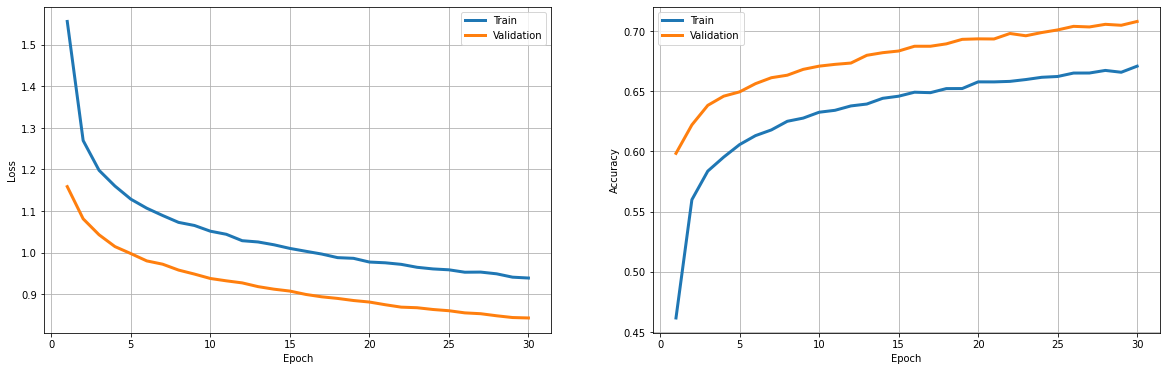

In [ ]:
plot_results(N_EPOCHS, train_losses_vgg16_feat_extract, train_accs_vgg16_feat_extract, valid_losses_vgg16_feat_extract, valid_accs_vgg16_feat_extract)

In [ ]:
model_testing(vgg16_feat_extract, test_iterator, criterion, device, 'vgg16_feat_extract.pt')

Test -- Loss: 0.939, Acc: 67.03 %


In [ ]:
print_report(vgg16_feat_extract, test_iterator, device)

[[692  24  41  20  19   4  13  29 106  52]
 [ 17 779   3  17   0   6   7   5  43 123]
 [ 74  12 504  45 119  56 130  44  14   2]
 [ 24  31  46 469  50 196 103  45  12  24]
 [ 27   4  61  33 598  29 107 126  10   5]
 [  9  14  43 103  48 671  32  61   9  10]
 [ 17   6  40  57  61  39 757  15   6   2]
 [ 27  11  26  39  70  64  10 711  10  32]
 [ 75  49  14  16  10   2   5   9 753  67]
 [ 30 117   2  11   3   6   3  11  43 774]]


              precision    recall  f1-score   support

           0       0.70      0.69      0.69      1000
           1       0.74      0.78      0.76      1000
           2       0.65      0.50      0.57      1000
           3       0.58      0.47      0.52      1000
           4       0.61      0.60      0.60      1000
           5       0.63      0.67      0.65      1000
           6       0.65      0.76      0.70      1000
           7       0.67      0.71      0.69      1000
           8       0.75      0.75      0.75      1000
           9       0.71   

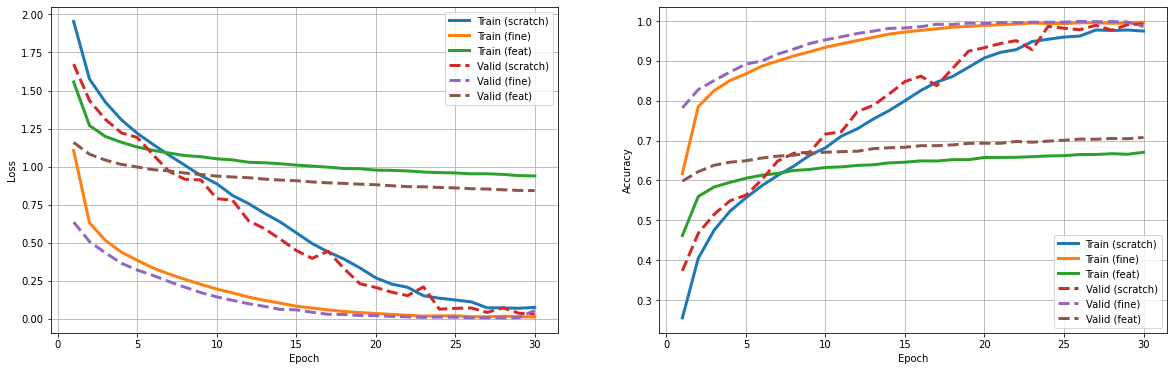

In [ ]:
# Plot all results
plt.figure(figsize=(20, 6))
_ = plt.subplot(1,2,1)
plt.plot(np.arange(N_EPOCHS)+1, train_losses_vgg16_scratch, linewidth=3)
plt.plot(np.arange(N_EPOCHS)+1, train_losses_vgg16_fine_tuning, linewidth=3)
plt.plot(np.arange(N_EPOCHS)+1, train_losses_vgg16_feat_extract, linewidth=3)
plt.plot(np.arange(N_EPOCHS)+1, valid_losses_vgg16_scratch, '--', linewidth=3)
plt.plot(np.arange(N_EPOCHS)+1, valid_losses_vgg16_fine_tuning, '--', linewidth=3)
plt.plot(np.arange(N_EPOCHS)+1, valid_losses_vgg16_feat_extract, '--', linewidth=3)
_ = plt.legend(['Train (scratch)', 'Train (fine)', 'Train (feat)', 'Valid (scratch)', 'Valid (fine)', 'Valid (feat)'])
plt.grid('on'), plt.xlabel('Epoch'), plt.ylabel('Loss')

_ = plt.subplot(1,2,2)
plt.plot(np.arange(N_EPOCHS)+1, train_accs_vgg16_scratch, linewidth=3)
plt.plot(np.arange(N_EPOCHS)+1, train_accs_vgg16_fine_tuning, linewidth=3)
plt.plot(np.arange(N_EPOCHS)+1, train_accs_vgg16_feat_extract, linewidth=3)
plt.plot(np.arange(N_EPOCHS)+1, valid_accs_vgg16_scratch, '--', linewidth=3)
plt.plot(np.arange(N_EPOCHS)+1, valid_accs_vgg16_fine_tuning, '--', linewidth=3)
plt.plot(np.arange(N_EPOCHS)+1, valid_accs_vgg16_feat_extract, '--', linewidth=3)
_ = plt.legend(['Train (scratch)', 'Train (fine)', 'Train (feat)', 'Valid (scratch)', 'Valid (fine)', 'Valid (feat)'])
plt.grid('on'), plt.xlabel('Epoch'), plt.ylabel('Accuracy')
plt.show()

# **CNN Contest**

Previous networks do not perform well on CIFAR-10 dataset. Design your own architecture (based on MLPs) and set the corresponding hyper-parameters in order to achieve better performance on the test set. Some parameters to focus on are listed below:

#### *Network's parameters*:

- Number of layers;
- Number of neurons per layer;
- Activation functions;
- Weights initialization;
- Dropout Rate.

#### *Training parameters*:
- Learning rate;
- Number of epochs;
- Optimizer;
- Batch size.

#### *Data*:
- Data augmentation.

You can also use different training techniques (e.g., early stopping, LR schedule) or consider ensemble methods.

#### *Pre-trained networks*:
- Use different pre-trained networks.